# 1. Setup

## 1.1 Install Dependencies

## 1.2 Import Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
from tensorflow.keras.models import Model
from tensorflow.python.data.ops import map_op

## 1.3 Set GPU Growth

In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
#to generate unique image names
import uuid

## 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [6]:
# http://vis-www.cs.umass.edu/lfw/

## 2.2 Collect Positive and Anchor Classes

In [7]:
# Import uuid library to generate unique image names
import uuid

In [58]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame=frame[90:250+90,200:450,:]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [9]:
anchor=tf.data.Dataset.list_files(ANC_PATH+r'\*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+r'\*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+r'\*.jpg').take(300)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data\\anchor\\c18225e3-4ef6-11ef-9e11-d4548b9202f6.jpg'


## 3.2 Preprocessing - Scale and Resize

In [12]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

## 3.3 Create Labelled Dataset

In [13]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
samples = data.as_numpy_iterator()

In [16]:
exampple = samples.next()

In [17]:
exampple

(b'data\\anchor\\fa2bf6bc-4ef6-11ef-b9e0-d4548b9202f6.jpg',
 b'data\\positive\\d377a9bc-4f7f-11ef-8c40-cd00f8a81435.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [18]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [19]:
res = preprocess_twin(*exampple)

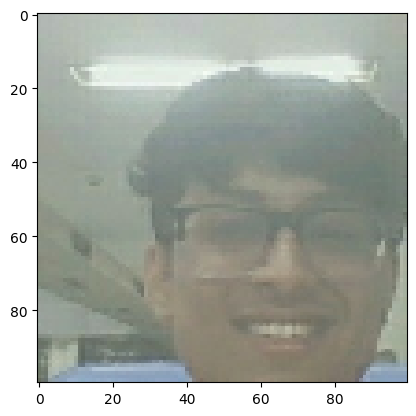

In [20]:
plt.imshow(res[1])

In [21]:
res[2]

1.0

In [22]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

## 4.2 Build Distance Layer

## 4.3 Make Siamese Model

In [25]:


# Define the custom L1 Distance layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Create a feature extraction model
def create_feature_extraction_model(input_shape):
    inp = Input(shape=input_shape)
    x = Conv2D(64, (10, 10), activation='relu')(inp)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (7,7), activation='relu')(x)
    x = MaxPooling2D(64, (2,2), padding='same')(x)
    x = Conv2D(256, (4,4), activation='relu')(x) 
    x = MaxPooling2D(256,(2,2),padding='same')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    return Model(inputs=inp, outputs=x)

# Create the Siamese model
def make_siamese_model():
    input_image = Input(name='input_image', shape=(100, 100, 3))
    validation_image = Input(name='validation_image', shape=(100, 100, 3))

    embedding_model = create_feature_extraction_model((100, 100, 3))

    input_embedding = embedding_model(input_image)
    validation_embedding = embedding_model(validation_image)

    siamese_layer = L1Dist()
    distances = siamese_layer(input_embedding, validation_embedding)

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier)

# Instantiate and compile the model
siamese_model = make_siamese_model()
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
siamese_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)      │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_image (InputLayer) │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_1 (Functional)     │ (None, 1024)              │      22,180,032 │ input_image[0][0],         │
│                               │                           │                 │ validation_image[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist (L1Dist)              │ (None, 1024)              │               0 │ functional_1[0][0],        │
│                               │                           │                 │ functional_1[1][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           1,025 │ l1_dist[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 22,181,057 (84.61 MB)

 Trainable params: 22,181,057 (84.61 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [26]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [27]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [29]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedi

In [30]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [31]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [32]:
EPOCHS = 20

In [33]:
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step

 Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step

 Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 949s 36s/step

 Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step

 Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step

 Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step

 Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step

 Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

 Epoch 15/20
27/27 ━━━━━━━

# 6. Evaluate Model

## 6.1 Import Metrics

In [34]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [35]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [36]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


array([[0.0000000e+00],
       [4.5770833e-36],
       [1.8198976e-33],
       [0.0000000e+00],
       [9.7955727e-08],
       [1.5638063e-26],
       [9.5695157e-16],
       [1.0000000e+00],
       [9.9999982e-01],
       [0.0000000e+00],
       [0.0000000e+00],
       [9.9999839e-01],
       [9.9999040e-01],
       [1.0000000e+00],
       [0.0000000e+00],
       [3.2144845e-31]], dtype=float32)

In [37]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]

In [38]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [39]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [40]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

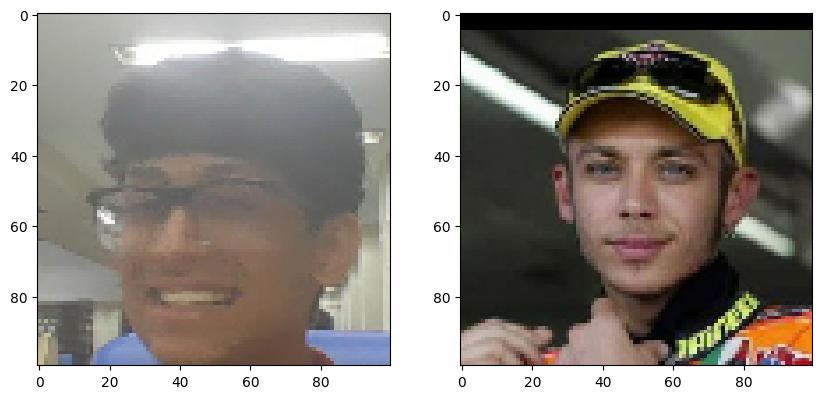

In [41]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [42]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [43]:
L1Dist

__main__.L1Dist

In [44]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [45]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


array([[0.0000000e+00],
       [4.5770833e-36],
       [1.8198976e-33],
       [0.0000000e+00],
       [9.7955727e-08],
       [1.5638063e-26],
       [9.5695157e-16],
       [1.0000000e+00],
       [9.9999982e-01],
       [0.0000000e+00],
       [0.0000000e+00],
       [9.9999839e-01],
       [9.9999040e-01],
       [1.0000000e+00],
       [0.0000000e+00],
       [3.2144845e-31]], dtype=float32)

In [46]:
# View model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)      │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_image (InputLayer) │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_1 (Functional)     │ (None, 1024)              │      22,180,032 │ input_image[0][0],         │
│                               │                           │                 │ validation_image[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist (L1Dist)              │ (None, 1024)              │               0 │ functional_1[0][0],        │
│                               │                           │                 │ functional_1[1][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           1,025 │ l1_dist[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 22,181,059 (84.61 MB)

 Trainable params: 22,181,057 (84.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [50]:
os.listdir(os.path.join('application_data', 'verification_images'))

['7a4f1091-4ef8-11ef-af40-d4548b9202f6.jpg',
 '7af4be81-4ef8-11ef-b511-d4548b9202f6.jpg',
 '7b0376b4-4ef8-11ef-ac70-d4548b9202f6.jpg',
 '7b1186ca-4ef8-11ef-9918-d4548b9202f6.jpg',
 '7b1864ea-4ef8-11ef-8816-d4548b9202f6.jpg',
 '7b26a06f-4ef8-11ef-bdbb-d4548b9202f6.jpg',
 '7b3554ae-4ef8-11ef-aecc-d4548b9202f6.jpg',
 '7b3e6e06-4ef8-11ef-89f0-d4548b9202f6.jpg',
 '7b4aec48-4ef8-11ef-8968-d4548b9202f6.jpg',
 '7b58d1ba-4ef8-11ef-b8e5-d4548b9202f6.jpg',
 '7b77dd5a-4ef8-11ef-8fa2-d4548b9202f6.jpg',
 '7b8b6cc5-4ef8-11ef-af9f-d4548b9202f6.jpg',
 '7b9755d3-4ef8-11ef-b085-d4548b9202f6.jpg',
 '7ba62cdd-4ef8-11ef-aaec-d4548b9202f6.jpg',
 '7baf2eb8-4ef8-11ef-9770-d4548b9202f6.jpg',
 '7bb3dd05-4ef8-11ef-afbb-d4548b9202f6.jpg',
 '7bc24988-4ef8-11ef-bb21-d4548b9202f6.jpg',
 '7bd2e3c8-4ef8-11ef-8c97-d4548b9202f6.jpg',
 '7be0e930-4ef8-11ef-ab0b-d4548b9202f6.jpg',
 '7bef14f6-4ef8-11ef-af84-d4548b9202f6.jpg',
 '7bf91cb3-4ef8-11ef-a116-d4548b9202f6.jpg',
 '7bfd6cd6-4ef8-11ef-bbd1-d4548b9202f6.jpg',
 '7c04a3c6

In [51]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [52]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\7a4f1091-4ef8-11ef-af40-d4548b9202f6.jpg
application_data\verification_images\7af4be81-4ef8-11ef-b511-d4548b9202f6.jpg
application_data\verification_images\7b0376b4-4ef8-11ef-ac70-d4548b9202f6.jpg
application_data\verification_images\7b1186ca-4ef8-11ef-9918-d4548b9202f6.jpg
application_data\verification_images\7b1864ea-4ef8-11ef-8816-d4548b9202f6.jpg
application_data\verification_images\7b26a06f-4ef8-11ef-bdbb-d4548b9202f6.jpg
application_data\verification_images\7b3554ae-4ef8-11ef-aecc-d4548b9202f6.jpg
application_data\verification_images\7b3e6e06-4ef8-11ef-89f0-d4548b9202f6.jpg
application_data\verification_images\7b4aec48-4ef8-11ef-8968-d4548b9202f6.jpg
application_data\verification_images\7b58d1ba-4ef8-11ef-b8e5-d4548b9202f6.jpg
application_data\verification_images\7b77dd5a-4ef8-11ef-8fa2-d4548b9202f6.jpg
application_data\verification_images\7b8b6cc5-4ef8-11ef-af9f-d4548b9202f6.jpg
application_data\verification_images\7b9755d3-4ef8-11ef-b085-d45

In [53]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [59]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [60]:
np.sum(np.squeeze(results) > 0.9)

49

In [ ]:
32/50